Data augmentation

In [141]:
import numpy as np 
import tensorflow as tf 
import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [142]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised = True,
)

In [143]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='C:\\Users\\muham\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [144]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


(-0.5, 499.5, 332.5, -0.5)

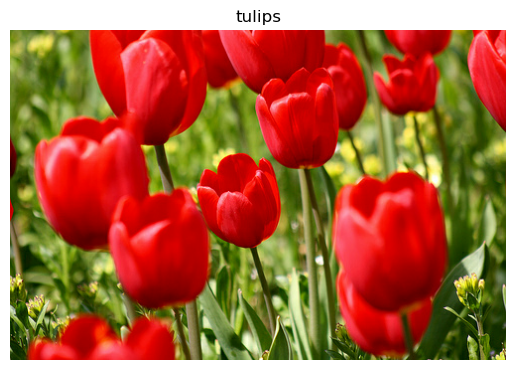

In [145]:
get_image_label = metadata.features['label'].int2str
image, label = next(iter(train_ds))
plt.imshow(image)
plt.title(get_image_label(label))
plt.axis('off')

## I cannot find the documentation of the above int2str?

In [146]:
img_height = 180
img_width = 180

resize_rescale = tf.keras.Sequential([
    layers.Resizing(img_height, img_width),
    layers.Rescaling(1./255)
])

RandomFlip /
RandomCrop /
RandomRotation /
RandomTranslation /
RandomZoom /
RandomContrast /
RandomBrightness /

In [147]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    # layers.RandomCrop(90, 90),
    layers.RandomRotation(.2),
    # layers.RandomTranslation(.1, 0.1),
    # layers.RandomZoom(.1),
    # layers.RandomBrightness(.3),
    # layers.RandomContrast(.6)
]
)

In [148]:
layers.RandomContrast?

Init signature: layers.RandomContrast(factor, seed=None, **kwargs)
Docstring:     
A preprocessing layer which randomly adjusts contrast during training.

This layer will randomly adjust the contrast of an image or images
by a random factor. Contrast is adjusted independently
for each channel of each image during training.

For each channel, this layer computes the mean of the image pixels in the
channel and then adjusts each component `x` of each pixel to
`(x - mean) * contrast_factor + mean`.

Input pixel values can be of any range (e.g. `[0., 1.)` or `[0, 255]`) and
in integer or floating point dtype.
By default, the layer will output floats.

**Note:** This layer is safe to use inside a `tf.data` pipeline
(independently of which backend you're using).

Input shape:
    3D (unbatched) or 4D (batched) tensor with shape:
    `(..., height, width, channels)`, in `"channels_last"` format.

Output shape:
    3D (unbatched) or 4D (batched) tensor with shape:
    `(..., height, width, chan

In [149]:
result = tf.cast(tf.expand_dims(image, 0), tf.float32)

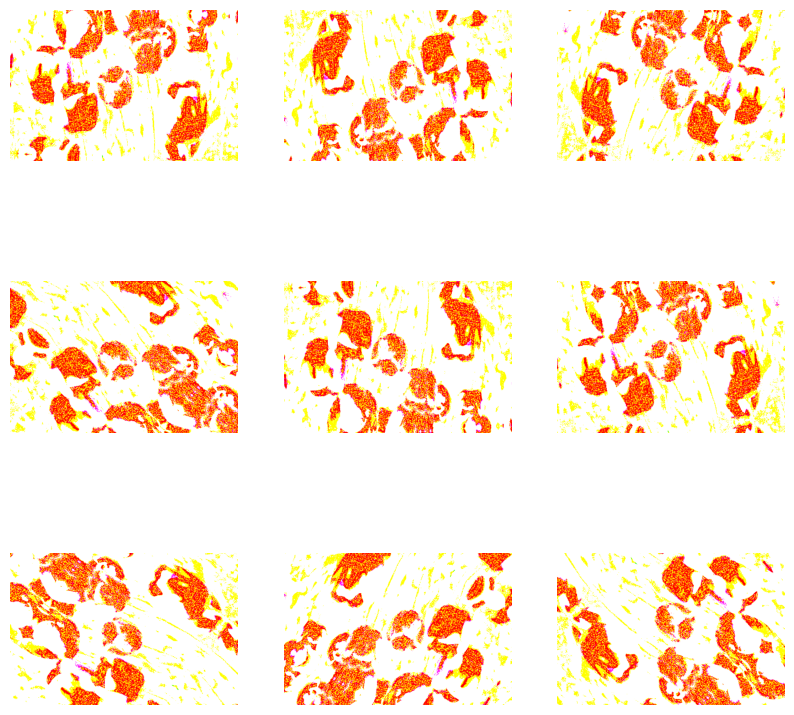

In [150]:
plt.figure(figsize = (10,10))

for i in range(9):
    augmented = data_augmentation(result)
    plt.subplot(3,3,i+1)
    plt.imshow(augmented[0])
    plt.axis('off')

In [151]:
aug_ds = train_ds.map( lambda x,y: (resize_rescale(x, training = True), y))

In [152]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle = False, augment = False):
    ds = ds.map(lambda x, y: (resize_rescale(x), y), num_parallel_calls = AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    if augment: 
        ds = ds.map(lambda x, y: (data_augmentation(x, training = True), y), num_parallel_calls = AUTOTUNE)
    return ds.prefetch(buffer_size = AUTOTUNE)

In [153]:
train_ds = prepare(train_ds, shuffle = True, augment = True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [154]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [155]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [156]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.3311 - loss: 1.6741 - val_accuracy: 0.5123 - val_loss: 1.1833
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 376ms/step - accuracy: 0.5049 - loss: 1.1807 - val_accuracy: 0.5804 - val_loss: 1.0522
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 283ms/step - accuracy: 0.5871 - loss: 1.0510 - val_accuracy: 0.5940 - val_loss: 1.0362
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.6215 - loss: 0.9701 - val_accuracy: 0.6403 - val_loss: 0.9865
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 252ms/step - accuracy: 0.6335 - loss: 0.9499 - val_accuracy: 0.6839 - val_loss: 0.9001


In [157]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

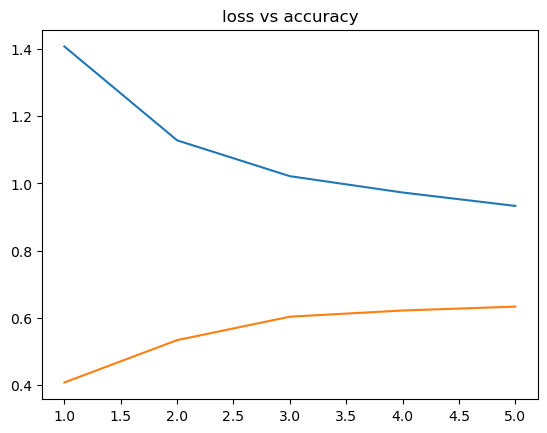

In [158]:
loss = history.history['loss']
accuracy = history.history['accuracy']
steps = range(1,epochs+1)

plt.figure(15)
plt.title('loss vs accuracy')
plt.plot(steps, loss, steps, accuracy)
plt.show()